# pwy_summary

In [2]:
from setup import (load_models,
                   convert_arg_to_list)
import pandas as pd 
from flux_ratio_analysis import (get_p_o_df, get_full_df)
from pathway_summary import (get_SG_pwy_df, get_pwy_rxn_df)
from growth_summary import (get_Biomass_df, get_desired_cycle, get_end_BM)
from pathway_summary import (get_rct_pathway_df,get_gene_pathway_df, 
                             get_gene_count_df, get_single_pathway_df)
from flux_snapshot import FluxCompare
from collections import Counter
import seaborn as sns
import ast

load_model_kwargs = { 
                'gal_scale': 3,
                'ac_scale': 10,
                'w': True
}

E0, S0, all_components = load_models(Egal_reuptake=False, **load_model_kwargs)

n_combos = 50
gene_combos = pd.read_csv('./Data/GeneCombos.csv',header=None)[0][:n_combos]
# DG_list = list(ast.literal_eval(ele) for ele in gene_combos) # list format
DG_list = list('.'.join(ast.literal_eval(ele)) for ele in gene_combos) # gene1.gene2 format


alpha_table = pd.read_csv("./Data/checkerboard_alpha_table.csv", index_col=0)
if len(alpha_table.columns) == 3:
    alpha_table.columns = ['E0', 'S0.ac', 'S0.glc']
else:
    alpha_table.lv_pairs = alpha_table.lv_pairs.apply(ast.literal_eval)
 
if 'Normal' in DG_list:
    DG_list.remove('Normal')
  
alpha_table = pd.read_csv("./Data/alpha_table_m1.csv", index_col=0) 
# Biomass summaries
Biomass_df = get_Biomass_df(['./Data/BM_SG_m1.csv', './Data/BM_DG_m1.csv'])
desired_cycle = get_desired_cycle(Biomass_df)
end_BM = get_end_BM(Biomass_df)

# pathway summary
rct_pathway_df = get_rct_pathway_df()
gene_pathway_df = get_gene_pathway_df(E0,alpha_table=alpha_table)

gene_count_df=get_gene_count_df(gene_pathway_df)
single_pathway_df = get_single_pathway_df(gene_pathway_df)
pwy_rxn_df = get_pwy_rxn_df(model=E0, E0=E0, S0=S0, alpha_table=alpha_table, DG_list=DG_list)

# calssification of drug combination effect
gr_DG = pd.read_csv('./Data/gr_DG_m1_normalized.csv', index_col=0)
p_o_full = get_p_o_df(E0, S0, gr_DG)



set alpha table None
LCTStex_lb 0
10 3 None 0
True
ACtex: ac_e <-- ac_p (-1000.0, 0.0)
ACtex: ac_e <-- ac_p (-1000.0, 0)
(0, 1000.0)
EX_ac_e: ac_e -->  ACtex: ac_e <-- ac_p
glyA reaction THRA not exist in list
glyA reaction THRA2 not exist in list
thrB reaction 4HTHRK not exist in list
glyA reaction THRA not exist in list
glyA reaction THRA2 not exist in list
thrB reaction 4HTHRK not exist in list


In [ ]:
# flux extraction
file_list = ['./Data/flanalysis_BM_SG_m1.json', './Data/flanalysis_BM_DG_m1.json']
FC_kwargs = {
            # 'desired_cycle':desired_cycle.loc[['folP.folA_5.4']],
            'desired_cycle':desired_cycle,
            # 'file_list':j, 
            'file_list':file_list, 
            'E0': E0,
            'S0': S0,
            'alpha_table': alpha_table,
            'culture_options':['monoculture','coculture'], 
            'item_options':'flux'}

FC = FluxCompare(**FC_kwargs)
FC.retrive_specific_culture()
# FC.flux_dict = flux_dict
flux_compare_df = FC.get_flux_compare_df()

# merge to form complete df for analysis
additional_df_list = end_BM, pwy_rxn_df, flux_compare_df
flux_analysis_full = get_full_df(desired_cycle=desired_cycle, p_o_full=p_o_full,
                                 additional_df_list=additional_df_list)

In [ ]:
flux_analysis_full.to_csv('./Data/flux_analysis_m1.csv')

# carbon allocation 

In [15]:
from importlib import reload
import flux_ratio_analysis

In [16]:
flux_analysis_full = pd.read_csv('./Data/flux_analysis_m1.csv', index_col=0)
co_E = flux_analysis_full.query('Species=="E0"')
reload(flux_ratio_analysis)
from flux_ratio_analysis import get_carbon_allocation_summary

carbon_allocation_E = pd.concat(co_E.apply(lambda x: 
                                           get_carbon_allocation_summary(x, E0, all_components,format=False), axis=1)
                                            .tolist())
carbon_allocation_rxns = get_carbon_allocation_summary(co_E.iloc[0], E0, all_components).index # carbon allocation fluxes

carbon_allocation_E_wide = carbon_allocation_E.reset_index().pivot(index='Gene_inhibition',columns='reaction',values=['total_carbon', 'percent'])
# carbon_allocation_E_pivot = carbon_allocation_E.pivot(index='Gene_inhibition',columns='reaction',values=['total_carbon', 'percent'])
carbon_allocation_E_wide.columns = ['_'.join([col[0], col[1]]) for col in carbon_allocation_E_wide.columns]
carbon_allocation_E_wide = p_o_full.query('Species=="E0"').merge(carbon_allocation_E_wide,left_index=True, right_index=True, how='outer')

# carbon_allocation_E_wide.to_csv('./Data/carbon_allocation.csv')
# # pairwise scatter plot for reach carbon terminal flux
# for x_col, y_col in itertools.combinations(carbon_allocation_rxns, 2):
#     carbon_allocation_E_long.plot.scatter('_'.join([prefix, x_col]), '_'.join([prefix, y_col]),c=color_list)


In [ ]:
import numpy as np

prefix='total_carbon'
prefix='percent'
x_col = 'EX_bulk_ac_e'
y_col = 'EX_lcts_e'
y_col = 'EX_lcts_e'
y_col = 'BIOMASS_Ec_iML1515_core_75p37M'
y_col = 'Waste'
# y_col = 'EX_co2_e'
def scatter_xycol(df, x_col, y_col, prefix='percent', XG=None):
    colors = {'Synergistic': 'red', 'Additive': 'purple', 'Antagonistic': 'blue', np.nan:'black'}
    # df.plot.scatter('total_carbon_EX_bulk_ac_e', 'total_carbon_Waste',c=color_list)
    if XG is not None:
        XG=convert_arg_to_list(XG)
        df = df.query('XG in @XG')
    color_list = [colors[group] for group in df['Drug_comb_effect']]
    df.plot.scatter('_'.join([prefix, x_col]), '_'.join([prefix, y_col])
                    ,c=color_list, title=prefix + ' ' +' vs '.join([y_col,x_col]))
# scatter_xycol(carbon_allocation_E_wide, x_col, y_col, XG='SG')
scatter_xycol(carbon_allocation_E_wide, x_col, y_col, XG='DG')

# ridge plots for percentage change compared to SG

In [131]:
def get_percent_cols(df, col_suffix=None, col_prefix='percent'):
    df = df.filter(regex=col_prefix)
    if not col_suffix:
        return df
    df = df.filter(like=col_suffix) 
    df.columns = df.columns.str.replace(col_suffix,'')
    return df

def get_sub_fs_change(fs_df, col_suffix='_First', col_prefix='percent'):
    fs = get_percent_cols(fs_df, col_suffix, col_prefix=col_prefix)
    fs_change = fs- get_percent_cols(carbon_allocation_E_wide.loc[fs.index], col_suffix=None, col_prefix=col_prefix) # change compared to single gene
    fs_change = fs_change.merge(carbon_allocation_E_wide[['Drug_comb_effect']], left_index=True, right_index=True).dropna(axis=0, how='all')
    return fs_change

def get_fs_change():
    gr_df = pd.read_csv('./Data/gr_DG_m1.csv', index_col=0)
    fs_df = carbon_allocation_E_wide.merge(gr_df[['First_gene', 'Second_gene']], left_index=True, right_index=True)

    fs_df = (fs_df.merge(carbon_allocation_E_wide, left_on='First_gene', right_index=True, suffixes=['','_First']) # add corresponding Frist and Second flux data
            .merge(carbon_allocation_E_wide, left_on='Second_gene', right_index=True, suffixes=['','_Second']))
    fs_change = pd.concat([get_sub_fs_change(fs_df, '_First'), get_sub_fs_change(fs_df, '_Second')])
    return fs_change

def plot_kde(plot_df, reaction=None, labels=['Waste', 'CO2', 'Acetate', 'Biomass'], col_prefix='percent_', common_norm=False, ylim=None): 
    sns.set_style('whitegrid', {'legend.frameon':True})
    color_dict = {
    'Waste': 'purple',
    'EX_co2_e': 'green',
    'EX_bulk_ac_e': 'blue',
    'BIOMASS_Ec_iML1515_core_75p37M': 'red',
    }
    color_dict = {col_prefix+k: v for k, v in color_dict.items()}

    plot_df.rename({'flux':'Portion change in carbon allocation'}, inplace=True, axis=1)
    print(plot_df.columns)
    g = sns.FacetGrid(plot_df, col="Drug_comb_effect")
    g.map_dataframe(sns.kdeplot, x="Portion change in carbon allocation", hue="reaction", fill=True, common_norm=common_norm, alpha=0.15, palette=color_dict)
    # g.map_dataframe(sns.kdeplot, x="flux", hue="reaction", fill=True, common_norm=True, alpha=0.2, palette=color_dict)
    if ylim:
        g.set(ylim=ylim)
    title = reaction if reaction else 'Change in Carbon Allocation Portion Profile (Double Gene minus Single Gene)'
    g.fig.suptitle(title, fontsize=8)
    # plt.legend(title='', loc='upper left', labels = color_dict.keys())
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    if not labels:
        labels = color_dict.keys
    col_prefix = 'percentage of \n total carbon uptaken' if col_prefix == 'percent_' else 'total carbon'
    plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0., title=f'Change in {col_prefix}', loc='upper left', labels = labels)



In [ ]:

fs_change = get_fs_change()
exclusion_rxns = ['EX_lcts_e', 'EX_for_e', 'EX_gal_e', 'EX_glyclt_e', 'EX_met__L_e']

fs_plot = fs_change.drop(['percent_EX_lcts_e', 'percent_EX_for_e', 'percent_EX_gal_e', 'percent_EX_glyclt_e', 'percent_EX_met__L_e'], axis=1)
# fs_plot = fs_plot.set_index('Drug_comb_effect', append=True).melt()
fs_plot = pd.melt(fs_plot, id_vars=['Drug_comb_effect'], var_name='reaction', value_name='flux')

# percentage change relative to single gene
antagonistic retain ability to cope with additional purturbation-by increase in % of waste

synergism - reduced flux through waste & # bimodal change in energy production response

Index(['Drug_comb_effect', 'reaction', 'Portion change in carbon allocation'], dtype='object')


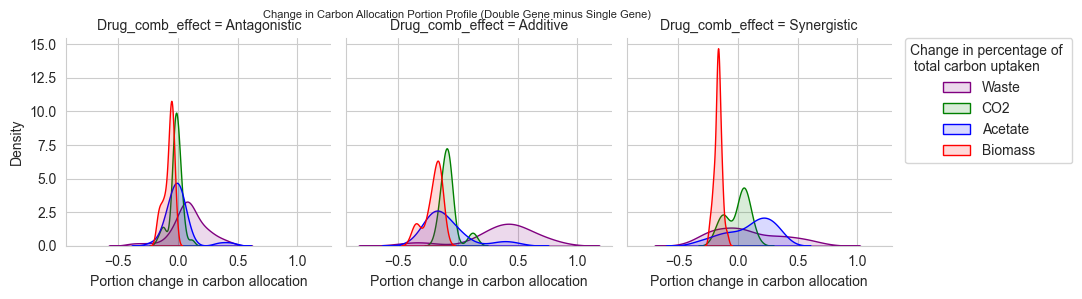

In [128]:
plot_kde(fs_plot)


# scatter plot 

add vector field


Text(0, 0.5, 'Change in portion of carbon allocated to CO2 production (%)')

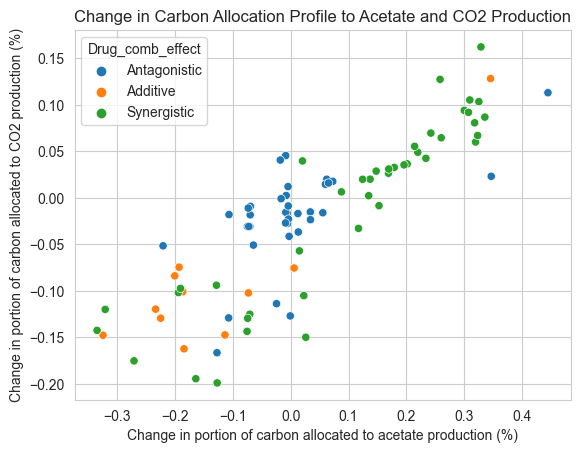

In [105]:
fs_to_plot = fs_change.merge(carbon_allocation_E_wide[['Drug_comb_effect']], left_index=True, right_index=True, suffixes=['','w']).dropna(axis=0, how='all')

def scatter_xycol(df, x_col, y_col, prefix='percent', XG=None):
    colors = {'Synergistic': 'red', 'Additive': 'purple', 'Antagonistic': 'blue', np.nan:'black'}
    # df.plot.scatter('total_carbon_EX_bulk_ac_e', 'total_carbon_Waste',c=color_list)
    if XG is not None:
        XG=convert_arg_to_list(XG)
        df = df.query('XG in @XG')
    color_list = [colors[group] for group in df['Drug_comb_effect']]
    # df.plot.scatter('_'.join([prefix, x_col]), '_'.join([prefix, y_col])
    #                 ,c=color_list, title=prefix + ' ' +' vs '.join([y_col,x_col]))
    sns.scatterplot(data=df, x='_'.join([prefix, x_col]), y='_'.join([prefix, y_col]), hue='Drug_comb_effect') 

y_col = 'EX_lcts_e'
y_col = 'BIOMASS_Ec_iML1515_core_75p37M'
y_col = 'Waste'
y_col = 'EX_co2_e'
prefix='percent'
x_col = 'EX_bulk_ac_e'
y_col = 'EX_lcts_e'
y_col = 'EX_lcts_e'
y_col = 'BIOMASS_Ec_iML1515_core_75p37M'
y_col = 'Waste'
y_col = 'EX_co2_e'
scatter_xycol(fs_to_plot, x_col, y_col)
plt.title('Change in Carbon Allocation Profile to Acetate and CO2 Production')
plt.xlabel('Change in portion of carbon allocated to acetate production (%)')
plt.ylabel('Change in portion of carbon allocated to CO2 production (%)')
# stable energy production pattern for antagonistic drug pairs

# metabolite allocation

In [ ]:
reload(flux_ratio_analysis)
from flux_ratio_analysis import get_metabolite_summary
# get_metabolite_summary(co_E.loc['folP'],'ac_c',model=E0, all_components=all_components)
 
ac_production_E = pd.concat(co_E.apply(lambda x: 
                                       get_metabolite_summary(x, 'atp_c',model=E0, all_components=all_components, concat=True)
                                       , axis=1)
                                       .tolist())
# ac_production_E.query('index=="ATPS4rpp"')
carbon_allocation_E_wide= ac_production_E.query('index=="BIOMASS_Ec_iML1515_core_75p37M"')
carbon_allocation_E_wide.merge(p_o_full.query("Species=='E0'")[['Drug_comb_effect']], left_on='Gene_inhibition', right_index=True)

# reduction in ratio compared to SG
# see if ratio changed between monocultue and coculture
    # -> indication of exclusion of methionine limiting effect

E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0


# GI effect >  methionine limiting 

In [ ]:
# locate the gene inhibition that inhibits E.coli
met_cm = flux_compare_df.query('Species=="E0"')[['EX_met__L_e','culture']]
# S>E
s = Biomass_df.filter(regex='coc').iloc[-1,::2]-list(Biomass_df.filter(regex='coc').iloc[-1,1::2])
swap_ratio = s[s<0]
sr_gc = {k.split('_')[1] :v for k, v in swap_ratio.to_dict().items()}
met_cm.query("Gene_inhibition in @sr_gc.keys()")

# energy pathway already overinhibition in m1

In [44]:
desired_items = ['Alternate Carbon Metabolism', 'Glycolysis/Gluconeogenesis', 'Pentose Phosphate Pathway', 'Citric Acid Cycle', 'Glycolysis/Gluconeogenesis', 'Pentose Phosphate Pathway']

expsingle = single_pathway_df.explode('Pathway_list').query('XG=="DG"').query('Pathway_list in @desired_items').index.unique()
expsingle

Index(['tktA.gnd', 'acnB.gltA', 'dadX.eno', 'gltA.gltD', 'acnB.ackA',
       'acnB.thrB', 'dadX.acnB', 'dapF.acnB', 'acnB.purT', 'dadX.gapA'],
      dtype='object', name='Gene_inhibition')

In [51]:
gr_df = pd.read_csv('./Data/gr_DG_m3_normalized.csv', index_col=0)
# gr_df.loc[expsingle].query('po_diff_E0_coculture<0')
gr_df.loc[expsingle]

,E0_coculture,S0_coculture,Predicted_additive_effect_E0_coculture,Predicted_additive_effect_S0_coculture,E0_monoculture,S0_monoculture,Predicted_additive_effect_E0_monoculture,Predicted_additive_effect_S0_monoculture,First_gene,E0_coculture_First_gene,...,E0_monoculture_Second_gene,S0_monoculture_Second_gene,po_diff_E0_coculture,po_diff_S0_coculture,po_diff_E0_monoculture,po_diff_S0_monoculture,po_diff_E0_coculture_rescaled_by_predicted,po_diff_S0_coculture_rescaled_by_predicted,po_diff_E0_monoculture_rescaled_by_predicted,po_diff_S0_monoculture_rescaled_by_predicted
Gene_inhibition,,,,,,,,,,,,,,,,,,,,,
tktA.gnd,0.110435,0.095062,0.143112,0.142288,0.474888,0.240061,0.787576,2.814898,tktA,0.473897,...,1.000000,5.796411,0.032677,0.047227,0.312688,2.574837,0.228315,0.331886,0.397021,0.914714
acnB.gltA,0.378069,0.375296,0.462223,0.461486,0.994315,0.567865,0.994530,0.626933,acnB,0.503855,...,0.998578,0.768911,0.084154,0.086190,0.000215,0.059068,0.182059,0.186762,0.000217,0.094216
dadX.eno,0.000000,0.000000,0.000000,0.000000,0.577242,0.576124,0.435429,2.473946,dadX,0.303165,...,0.601041,4.246922,0.000000,0.000000,-0.141813,1.897823,0.000000,0.000000,-0.325678,0.767120
gltA.gltD,2.362263,2.519882,1.263583,1.258156,0.562087,0.768912,0.565969,4.457010,gltA,0.917372,...,0.566776,5.796524,-1.098680,-1.261726,0.003883,3.688098,-0.869489,-1.002830,0.006860,0.827481
acnB.ackA,0.000000,0.000000,0.000000,0.000000,0.870943,0.253301,0.870062,4.374052,acnB,0.503855,...,0.873603,5.364615,0.000000,0.000000,-0.000881,4.120752,0.000000,0.000000,-0.001012,0.942088
acnB.thrB,0.258932,0.256804,0.270239,0.267562,0.476470,0.487638,0.474539,0.487543,acnB,0.503855,...,0.476470,0.597954,0.011307,0.010758,-0.001931,-0.000095,0.041838,0.040206,-0.004070,-0.000194
dadX.acnB,0.150023,0.141999,0.152751,0.150125,0.724458,0.473821,0.721521,0.474965,dadX,0.303165,...,0.995947,0.815353,0.002729,0.008125,-0.002936,0.001144,0.017863,0.054121,-0.004070,0.002408
dapF.acnB,0.163551,0.156895,0.100718,0.099560,0.551514,0.474477,0.549278,3.334415,dapF,0.199895,...,0.995947,0.815353,-0.062833,-0.057335,-0.002235,2.859938,-0.623787,-0.575826,-0.004070,0.857700
acnB.purT,0.000000,0.000000,0.000000,0.000000,0.870943,0.253301,0.870062,4.374052,acnB,0.503855,...,0.873603,5.364615,0.000000,0.000000,-0.000881,4.120752,0.000000,0.000000,-0.001012,0.942088


In [5]:
query_pwy = ['a']
expsingle.query

,XG,Pathway_count,Pathway_list,Single_pathway
Gene_inhibition,,,,
aroA.pheA,DG,1,"Tyrosine, Tryptophan, and Phenylalanine Metabo...",Single_pathway
dapA.dapF,DG,1,Threonine and Lysine Metabolism,Single_pathway
dapF.dapD,DG,1,Threonine and Lysine Metabolism,Single_pathway
folC.folA,DG,1,Cofactor and Prosthetic Group Biosynthesis,Single_pathway
folP.folA,DG,1,Cofactor and Prosthetic Group Biosynthesis,Single_pathway
...,...,...,...,...
aroA.serC,DG,4,"Tyrosine, Tryptophan, and Phenylalanine Metabo...",Multi_pathway
dadX.gapA,DG,4,Metabolite Repair,Multi_pathway
dadX.gapA,DG,4,Alanine and Aspartate Metabolism,Multi_pathway


In [ ]:
single_pathway_df.loc['s`erC'].Pathway_list

['Cofactor and Prosthetic Group Biosynthesis',
 'Threonine and Lysine Metabolism',
 'Glycine and Serine Metabolism']

In [ ]:
single_pathway_df.loc[['serC.dapD']].Pathway_list[0]

['Threonine and Lysine Metabolism',
 'Cofactor and Prosthetic Group Biosynthesis',
 'Glycine and Serine Metabolism']

In [ ]:
import pandas as pd

pd.set_option('display.max_rows', 200)
met_cm[:200]

met_cm[:200]

EX_met__L_e      culture
Gene_inhibition Species                           
Normal          E0      -2.031147e-02    coculture
                E0      -4.816149e-02  monoculture
aceF            E0                NaN    coculture
                E0      -4.816149e-02  monoculture
ackA            E0                NaN    coculture
                E0      -9.885089e-02  monoculture
acnB            E0                NaN    coculture
                E0      -7.931557e-02  monoculture
acnB.ackA       E0                NaN    coculture
                E0      -8.035044e-02  monoculture
acnB.gltA       E0                NaN    coculture
                E0      -1.108499e-02  monoculture
acnB.purT       E0                NaN    coculture
                E0      -8.035044e-02  monoculture
acnB.thrB       E0                NaN    coculture
                E0      -4.725718e-02  monoculture
argD            E0      -4.467975e-03    coculture
                E0      -7.853135e-02  monoculture
aroA            E0      -7.048711e-03    coculture
                E0      -7.944929e-02  monoculture
aroA.argD       E0      -3.068767e-03    coculture
                E0      -6.404948e-02  monoculture
aroA.dapB       E0      -4.423174e-03    coculture
                E0      -5.142532e-02  monoculture
aroA.dapF       E0      -2.749576e-03    coculture
                E0      -5.592245e-02  monoculture
aroA.guaB       E0      -4.347683e-03    coculture
                E0      -7.921701e-02  monoculture
aroA.pheA       E0      -1.127570e-05    coculture
                E0      -7.135789e-03  monoculture
aroA.serC       E0      -4.518932e-03    coculture
                E0      -6.229874e-02  monoculture
dadX            E0      -4.838303e-03    coculture
                E0      -4.626851e-02  monoculture
dadX.acnB       E0                NaN    coculture
                E0      -4.626851e-02  monoculture
dadX.aroA       E0      -3.242041e-03    coculture
                E0      -4.626851e-02  monoculture
dadX.eno        E0                NaN    coculture
                E0      -4.626851e-02  monoculture
dadX.gapA       E0                NaN    coculture
                E0      -4.311301e-02  monoculture
dadX.guaB       E0      -3.366522e-03    coculture
                E0      -4.626851e-02  monoculture
dadX.mrcA       E0      -8.735957e-04    coculture
                E0      -2.393854e-03  monoculture
dadX.mrdA       E0      -2.073130e-05    coculture
                E0      -9.073162e-04  monoculture
dadX.pheA       E0      -2.976208e-03    coculture
                E0      -4.626851e-02  monoculture
dadX.pyrD       E0      -3.105162e-03    coculture
                E0      -4.626851e-02  monoculture
dadX.rffG       E0      -3.249932e-03    coculture
                E0      -4.626851e-02  monoculture
dapA            E0      -5.717919e-03    coculture
                E0      -7.231479e-02  monoculture
dapA.aroA       E0      -3.625959e-03    coculture
                E0      -6.244389e-02  monoculture
dapA.dapF       E0      -4.880459e-04    coculture
                E0      -5.494356e-03  monoculture
dapA.serC       E0      -6.180000e-08    coculture
                E0      -9.444175e-03  monoculture
dapB            E0      -7.803684e-03    coculture
                E0      -5.262676e-02  monoculture
dapD            E0      -6.623538e-03    coculture
                E0      -6.426737e-02  monoculture
dapF            E0      -3.829452e-03    coculture
                E0      -5.592245e-02  monoculture
dapF.acnB       E0                NaN    coculture
                E0      -5.592245e-02  monoculture
dapF.dapD       E0      -1.310650e-04    coculture
                E0      -4.481808e-03  monoculture
dapF.pheA       E0      -2.554754e-03    coculture
                E0      -5.592245e-02  monoculture
eno             E0                NaN    coculture
                E0      -6.184486e-02  monoculture
fbp             E0      -2.031147e-02    cocultu

In [ ]:
# ES cross feeding flux ratio

In [59]:
flux_analysis_full.Species

Gene_inhibition
Normal       E0
Normal       S0
mrdA.mrcA    E0
mrdA.mrcA    S0
serC.dapD    E0
             ..
purN         S0
rffG         E0
rffG         S0
gapA         E0
gapA         S0
Name: Species, Length: 196, dtype: object

In [68]:
cf.merge(flux_analysis_full[['XG']], left_index=True, right_index=True, how='left')

,EX_bulk_ac_e,BIOMASS_iRR1083_metals
Gene_inhibition,,
Normal,0.263927,0.131970
mrdA.mrcA,0.621298,0.112535
serC.dapD,0.900122,0.050298
serC.dapB,0.588678,0.037028
mrdA.aroA,0.139798,0.035092
...,...,...
purU,0.265475,0.132689
serA,0.337996,0.163129
gltD,0.386837,0.186972


In [71]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'S. enterica Methionine Secretion')

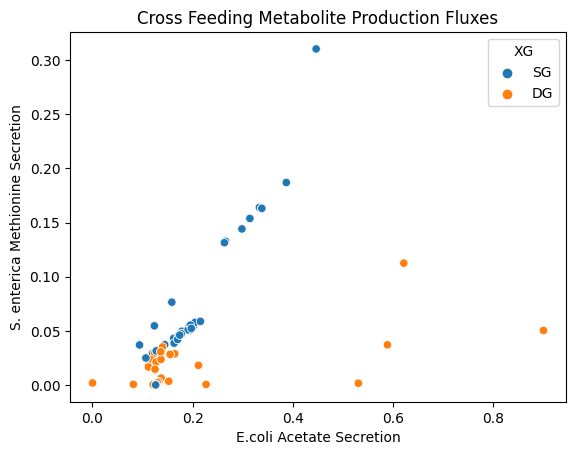

In [73]:
# cross_m = flux_compare_df.query('XG=="SG"').query("culture=='coculture'")[['EX_bulk_ac_e', 'BIOMASS_iRR1083_metals']]
cross_m = flux_analysis_full.set_index('Species', append=True)[['EX_bulk_ac_e', 'BIOMASS_iRR1083_metals', 'XG']]
# cross_m = cross_m
cross_E = cross_m.query('Species=="E0"')[['EX_bulk_ac_e']].reset_index('Species',drop=True)
cross_S = cross_m.query('Species=="S0"')[['BIOMASS_iRR1083_metals']].reset_index('Species',drop=True)
cf = cross_E.merge(cross_S, left_index=True, right_index=True).dropna()
cf = cf.merge(flux_analysis_full[['XG']], left_index=True, right_index=True, how='left')

# cf.plot.scatter(x='EX_bulk_ac_e', y='BIOMASS_iRR1083_metals', hue='XG')

sns.scatterplot(cf,x='EX_bulk_ac_e', y='BIOMASS_iRR1083_metals', hue='XG')
# plt.title('Cross Feeding Metabolite Production Fluxes')
plt.xlabel('E.coli Acetate Secretion')
plt.ylabel('S. enterica Methionine Secretion')

In [ ]:
colors = {'Synergistic': 'orange', 'Additive': 'purple', 'Antagonistic': 'blue'}
color_list = [colors[group] for group in carbon_allocation_E_wide['categorical_variable']]

# Create a scatter plot with color-coding based on 'categorical_variable'
ax = carbon_allocation_E_wide.plot.scatter('variable1',
                'variable2',
                c=color_list,

In [ ]:
cf.merge(flux_analysis_full[['Drug_comb_effect']], left_index=True, right_index=True)

,EX_bulk_ac_e,BIOMASS_iRR1083_metals,Drug_comb_effect
Gene_inhibition,,,
aroA.argD,0.121148,0.019932,Antagonistic
aroA.argD,0.121148,0.019932,Antagonistic
aroA.dapB,0.164185,0.028739,Antagonistic
aroA.dapB,0.164185,0.028739,Antagonistic
aroA.dapF,0.111557,0.017855,Antagonistic
aroA.dapF,0.111557,0.017855,Antagonistic
aroA.guaB,0.154966,0.028248,Antagonistic
aroA.guaB,0.154966,0.028248,Antagonistic
aroA.pheA,0.126190,0.000025,Synergistic


Index(['EX_lcts_e', 'EX_bulk_ac_e', 'Drug_comb_effect', 'XG'], dtype='object')


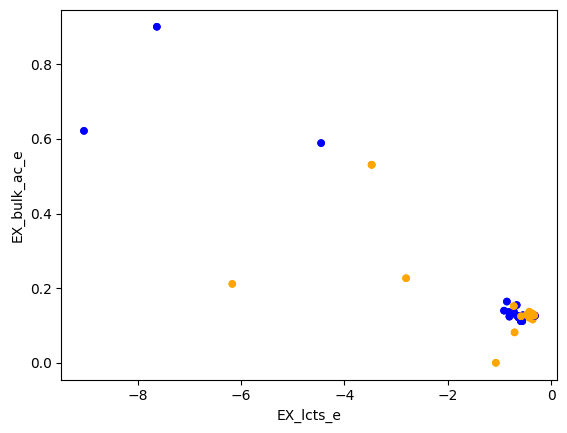

In [ ]:
def plot_flux_ratio(E_col, S_col, XG=['DG'], culture='coculture', Species=['E0', 'S0']):
# cross_m = flux_compare_df.query('XG=="DG"').query("culture=='coculture'")[['EX_bulk_ac_e', 'BIOMASS_iRR1083_metals']]
    if XG is not None:
        cross_m = flux_compare_df
    cross_m = flux_compare_df.query('XG in @XG').query("culture==@culture")
    
    cross_m = cross_m[[E_col, S_col]]
    cross_E = cross_m.query('Species==@Species[0]')[[E_col]].reset_index('Species',drop=True)
    cross_S = cross_m.query('Species==@Species[1]')[[S_col]].reset_index('Species',drop=True)

    # cf = cross_E.merge(cross_S, left_index=True, right_index=True, suffixes=['E','S']).dropna()
    cf = cross_E.merge(cross_S, left_index=True, right_index=True, suffixes=Species).dropna().T.drop_duplicates().T
    cf = cf.merge(flux_analysis_full[['Drug_comb_effect', 'XG']], left_index=True, right_index=True, how='left')
    
    colors = {'Synergistic': 'orange', 'Additive': 'purple', 'Antagonistic': 'blue'}
    color_list = [colors[group] for group in cf['Drug_comb_effect']]

    print(cf.columns)
    if E_col==S_col:
        E_col, S_col = E_col+'E', S_col+'S'
    # return cf
    cf.plot.scatter(x=E_col, y=S_col,c=color_list)
    
    
plot_flux_ratio('EX_lcts_e', 'EX_bulk_ac_e', Species=['E0','E0'])
# cf = plot_flux_ratio('EX_bulk_ac_e', 'EX_bulk_ac_e', XG=['DG'])

In [ ]:
cf

,EX_bulk_ac_eE,EX_bulk_ac_eS,Drug_comb_effect,XG
Gene_inhibition,,,,
aroA.argD,0.121148,-0.378202,Antagonistic,DG
aroA.argD,0.121148,-0.378202,Antagonistic,DG
aroA.dapB,0.164185,-0.503992,Antagonistic,DG
aroA.dapB,0.164185,-0.503992,Antagonistic,DG
aroA.dapF,0.111557,-0.349604,Antagonistic,DG
aroA.dapF,0.111557,-0.349604,Antagonistic,DG
aroA.guaB,0.154966,-0.476150,Antagonistic,DG
aroA.guaB,0.154966,-0.476150,Antagonistic,DG
aroA.pheA,0.126190,-0.136981,Synergistic,DG


<Axes: xlabel='EX_bulk_ac_e', ylabel='BIOMASS_iRR1083_metals'>

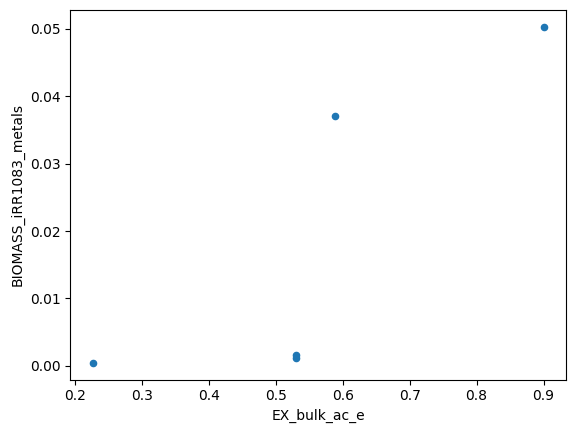

In [ ]:
cf.loc[sr_gc.keys()].plot.scatter(x='EX_bulk_ac_e', y='BIOMASS_iRR1083_metals')

<Axes: xlabel='EX_bulk_ac_e', ylabel='BIOMASS_iRR1083_metals'>

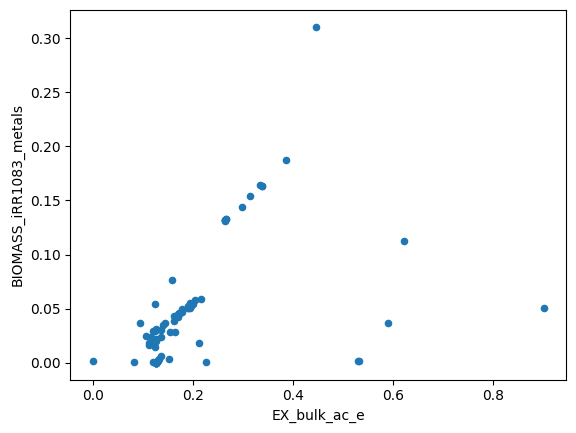